In [1]:
import os
import copy

import networkx as nx
import h5py
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import sklearn
import multiscale_phate as msp

In [2]:
os.chdir('..')
import manifold_methods
import plotting
import mappings
import data_loader

import graph_viz_utils

## Try analysis with genetics dataset

In [3]:
path_to_data = '/lustre06/project/6065672/sciclun4/ActiveProjects/THING/data/1KG_HGDP'

In [13]:
inputs = np.load(os.path.join(path_to_data, 'hgdp_data.npy'))

In [14]:
samples = pd.read_csv(os.path.join(path_to_data, 'samples'), sep=',').set_index('0')

In [15]:
# load metadata, labels
labels = pd.read_csv(os.path.join(path_to_data, 'metadata_labels_hgdp'), sep=',').set_index('sample')
coords = pd.read_csv(os.path.join(path_to_data, '1KG_HGDP_coords.txt'), sep='\t').set_index('SampleID')

In [21]:
# keep points that have label and coord info
# Only 1000G
#labels_1000G = labels[labels['db'] == '1000G'].index
to_keep = list(set(samples.index).intersection(labels.index).intersection(coords.index))

In [24]:
labels = labels.loc[to_keep]
coords = coords.loc[to_keep]

In [25]:
inputs = pd.DataFrame(inputs, index=samples.index).loc[to_keep].values

In [26]:
label_order_1000G_coarse = ['EAS', 'EUR', 'AFR', 'AMR', 'SAS']

# Raph request I use this color palette
pop_pallette_1000G_coarse = {'EAS': 'blue',
                             'EUR': 'purple',
                             'AMR': 'red',
                             'AFR': 'green',
                             'SAS': 'orange'
                            }

label_order_1000G_fine = ['YRI', 'ESN', 'GWD', 'LWK', 'MSL', 'ACB', 'ASW',
                           'IBS',  'CEUGBR', 'TSI', 'FIN',
                           'PJL', 'BEB', 'GIH', 'STUITU',
                           'CHB', 'CHS', 'CDX', 'KHV', 'JPT',
                           'MXL', 'CLM', 'PEL', 'PUR']

pop_colors=["#C7E9C0","#A1D99B","#74C476","#41AB5D","#238B45","#006D2C","#00441B",
            "#EFBBFF","#D896FF","#BE29EC","#800080",
            "#FEEDDE","#FDBE85","#FD8D3C","#E6550D",
            "#DEEBF7","#9ECAE1","#008080","#0ABAB5","#08519C",
           "#BC544B","#E3242B","#E0115F","#900D09","#7E2811"]

pop_pallette_1000G_fine = {label:color for label,color in zip(label_order_1000G_fine, pop_colors)}

def make_palette_label_order_HGDP(metadata_labels):
    # SAS -> CSA + add MID, OCE
    pop_palette_hgdp_coarse = copy.deepcopy(pop_pallette_1000G_coarse)
    pop_palette_hgdp_coarse['CSA'] = pop_pallette_1000G_coarse['SAS']
    pop_palette_hgdp_coarse.pop('SAS')

    pop_palette_hgdp_coarse['MID'] = 'grey'
    pop_palette_hgdp_coarse['OCE'] = 'yellow'

    label_order_hgdp_coarse = copy.deepcopy(label_order_1000G_coarse)
    label_order_hgdp_coarse.remove('SAS')
    label_order_hgdp_coarse += ['CSA', 'MID', 'OCE']

    # Keep original 24/26 populations (with colors), and add new ones. New pops colored using superpop
    label_order_hgdp_fine = []
    for super_pop in np.unique(metadata_labels['Superpopulation']):
        for pop in np.unique(metadata_labels['Population'][metadata_labels['Superpopulation']==super_pop]):
            label_order_hgdp_fine.append(pop)

    # create tmp object to hold the original 26 populations
    mapping_26 = copy.deepcopy(pop_pallette_1000G_fine)
    mapping_26['GBR'] = mapping_26['CEUGBR']
    mapping_26['CEU'] = mapping_26['CEUGBR']
    mapping_26['STU'] = mapping_26['STUITU']
    mapping_26['ITU'] = mapping_26['STUITU']

    pop_palette_hgdp_fine = {}

    for super_pop in np.unique(metadata_labels['Superpopulation']):
        for pop in np.unique(metadata_labels['Population'][metadata_labels['Superpopulation']==super_pop]):
            if pop not in mapping_26.keys():
                # just use superpop color for now
                pop_palette_hgdp_fine[pop] = pop_palette_hgdp_coarse[super_pop]
            else:
                pop_palette_hgdp_fine[pop] = mapping_26[pop]

    return pop_palette_hgdp_coarse, pop_palette_hgdp_fine, label_order_hgdp_coarse, label_order_hgdp_fine

pop_palette_hgdp_coarse, pop_palette_hgdp_fine, label_order_hgdp_coarse, label_order_hgdp_fine = make_palette_label_order_HGDP(labels)

## Regular MSPHATE

In [28]:
msp_op = msp.Multiscale_PHATE(random_state=1)

levels = msp_op.fit(inputs)

Calculating Multiscale PHATE tree...
  Calculating PCA...
  Calculated PCA in 77.83 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 13.21 seconds.
  Setting epsilon to 3.3563
  Setting merge threshold to 0.001
  Calculating condensation...
  Calculated condensation in 2.44 seconds.
Calculated Multiscale PHATE tree in 93.59 seconds.
Computing gradient...
Identifying salient levels of resolution...


In [30]:
#path_to_table = 'results/msphate_1K'

metadata_msphate = graph_viz_utils.make_table(msp_op, 
                                        labels, 
                                        keys=['Population', 'Superpopulation'])

#metadata_msphate.to_csv(path_to_table)
#print('Saved MS-PHATE metadata table to {}'.format(path_to_table))

done level 0
done level 7
done level 78
done level 88
done level 101
done level 116
done level 122
done level 130
done level 136
done level 144
done level 153
done level 164
Calculating base visualization...
Calculated base visualization in 3.87 seconds.
Calculating tree...
Calculated tree in 0.09 seconds.


In [31]:
DG = graph_viz_utils.make_directed_tree(msp_op)

In [32]:
## Visualization
root = '{}_0'.format(len(msp_op.NxTs)-1) # name convention
max_level = 5

subtree = graph_viz_utils.get_subgraph_up_to_level(DG, root, max_level)
subtree_simplified, _ = graph_viz_utils.remove_unneeded_nodes(subtree)

node_colors, node_sizes = graph_viz_utils.get_node_color_size(subtree_simplified,
                                                        metadata_msphate, 
                                                        'Superpopulation', 
                                                        pop_palette_hgdp_coarse)

pos_hier = graph_viz_utils.hierarchical_layout(subtree_simplified, root, min_spacing=0.1)
pos_rad = graph_viz_utils.radial_layout(subtree_simplified, root, vert_gap=0.2, vert_loc=0)

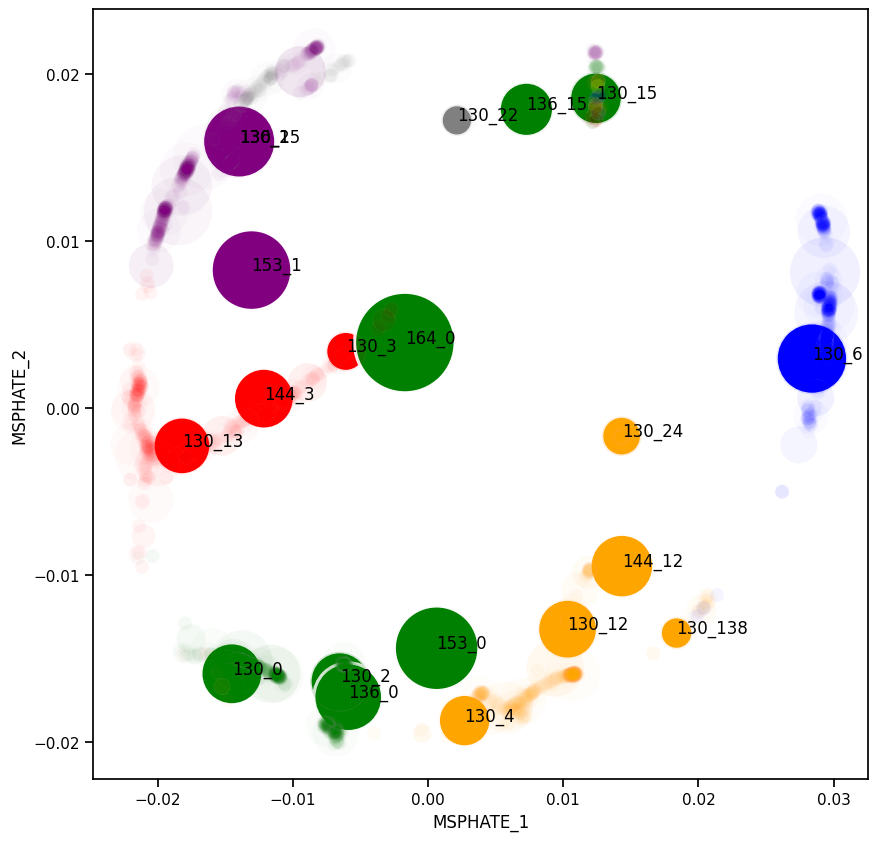

In [33]:
sns.set_context('notebook')

to_plot = metadata_msphate[metadata_msphate['NodeName'].isin(list(subtree_simplified.nodes()))]
sizes=100*np.sqrt(to_plot['sizes'].values)
sizes2 = 100*np.sqrt(metadata_msphate['sizes'].values)

fig, ax = plt.subplots(figsize=(10,10))
sns.scatterplot(x=to_plot['MSPHATE_1'], 
                y=to_plot['MSPHATE_2'], 
                hue=to_plot['Superpopulation'], 
                size=sizes, 
                sizes=(sizes.min(), sizes.max()),
                palette=pop_palette_hgdp_coarse,
                ax=ax)

sns.scatterplot(x=metadata_msphate['MSPHATE_1'], 
                y=metadata_msphate['MSPHATE_2'], 
                hue=metadata_msphate['Superpopulation'], 
                size=sizes2, 
                sizes=(sizes2.min(), sizes2.max()),
                palette=pop_palette_hgdp_coarse,
                alpha=0.02,
                ax=ax)

for row in to_plot.iterrows():
    ax.text(row[1].MSPHATE_1, row[1].MSPHATE_2, row[1].NodeName)
ax.get_legend().remove()

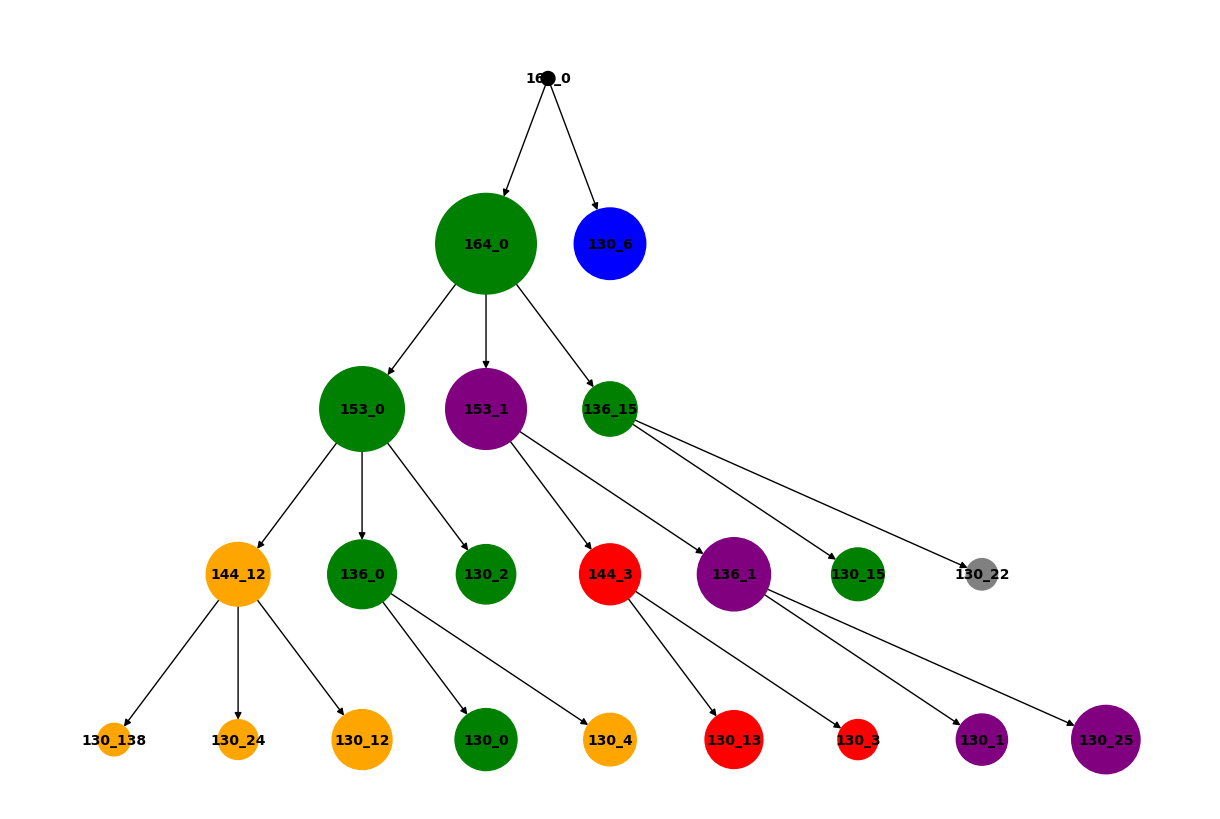

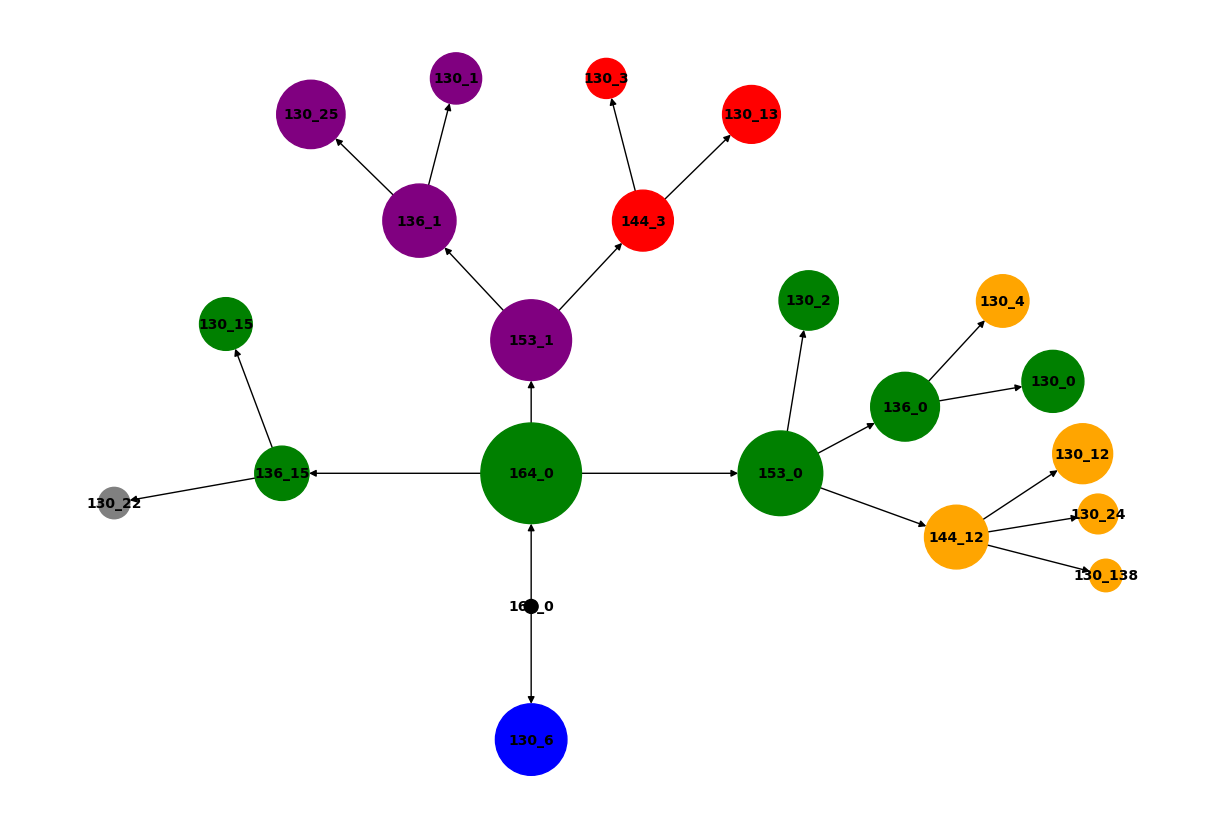

In [36]:
# Draw the graph
plt.figure(figsize=(12, 8))
nx.draw(subtree_simplified, 
        pos_hier, 
        with_labels=True, 
        node_size=node_sizes, 
        font_size=10, 
        font_weight='bold', 
        node_color=node_colors) #connectionstyle="bar,angle=180,fraction=-0.0"
plt.show()

plt.figure(figsize=(12, 8))
nx.draw(subtree_simplified, 
        pos_rad, 
        with_labels=True, 
        node_size=node_sizes, 
        font_size=10, 
        font_weight='bold', 
        node_color=node_colors) #connectionstyle="bar,angle=180,fraction=-0.0"
plt.show()

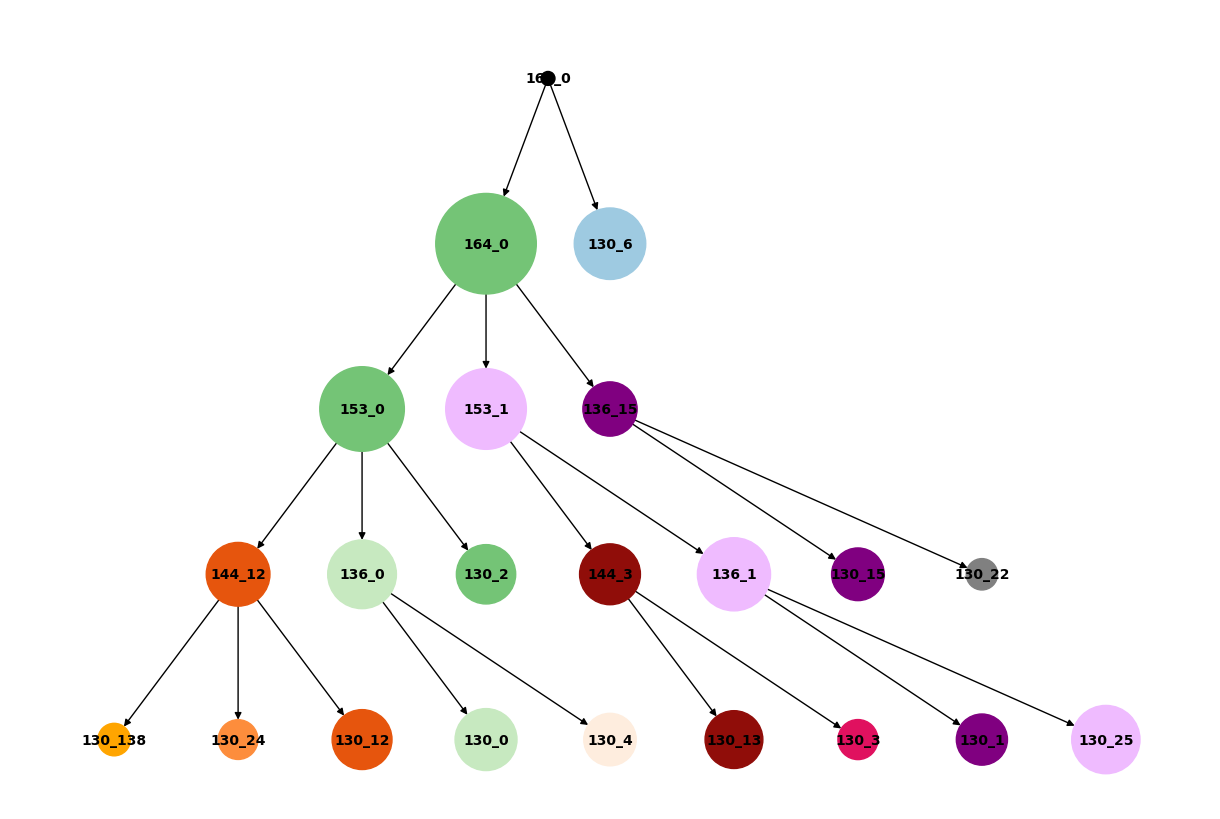

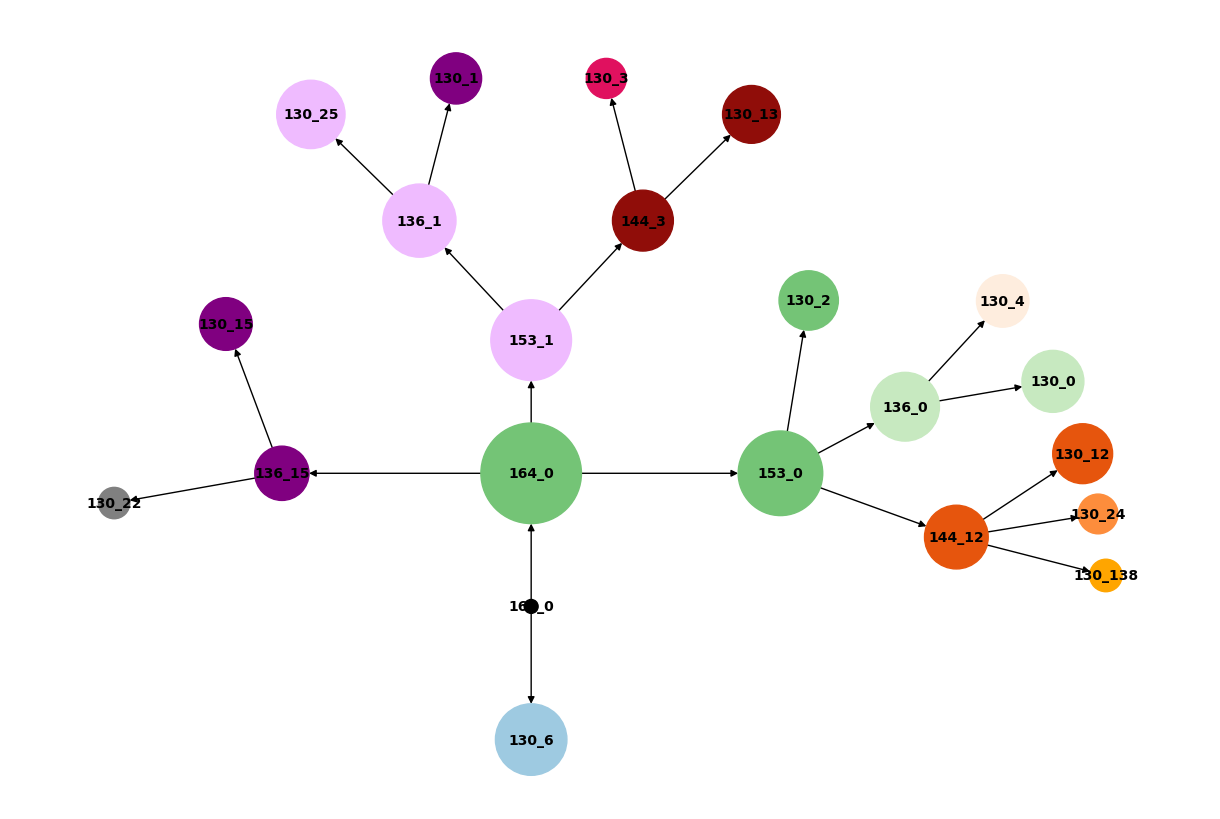

In [37]:
node_colors, node_sizes = graph_viz_utils.get_node_color_size(subtree_simplified,
                                              metadata_msphate, 
                                              'Population', 
                                              pop_palette_hgdp_fine)

pos_hier = graph_viz_utils.hierarchical_layout(subtree_simplified, root, min_spacing=0.1)
pos_rad = graph_viz_utils.radial_layout(subtree_simplified, root, vert_gap=0.2, vert_loc=0)

# Draw the graph
plt.figure(figsize=(12, 8))
nx.draw(subtree_simplified, 
        pos_hier, 
        with_labels=True, 
        node_size=node_sizes, 
        font_size=10, 
        font_weight='bold', 
        node_color=node_colors) #connectionstyle="bar,angle=180,fraction=-0.0"
plt.show()

plt.figure(figsize=(12, 8))
nx.draw(subtree_simplified, 
        pos_rad, 
        with_labels=True, 
        node_size=node_sizes, 
        font_size=10, 
        font_weight='bold', 
        node_color=node_colors) #connectionstyle="bar,angle=180,fraction=-0.0"
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


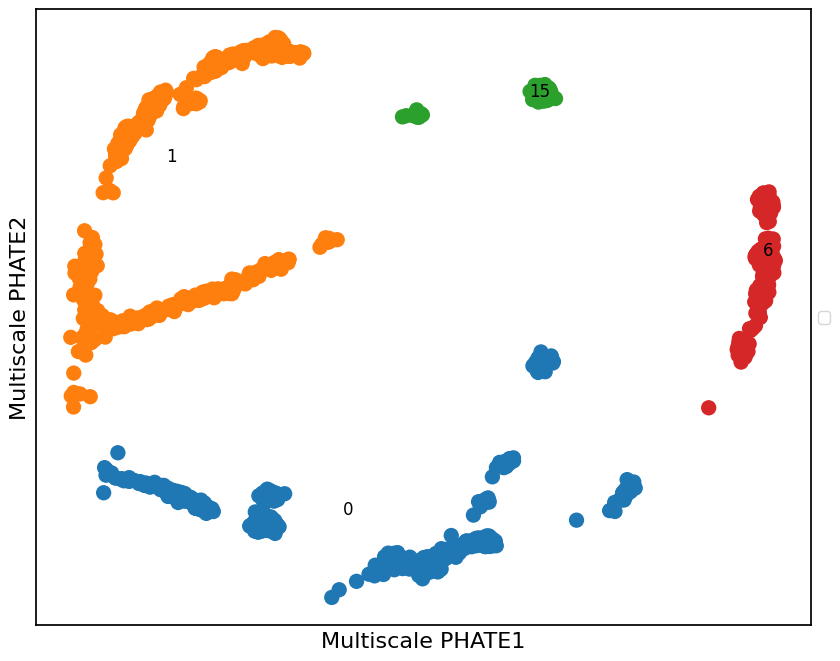

In [38]:
graph_viz_utils.plot_msphate(msp_op, levels, level_ind=10, palette=None, labels=None)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


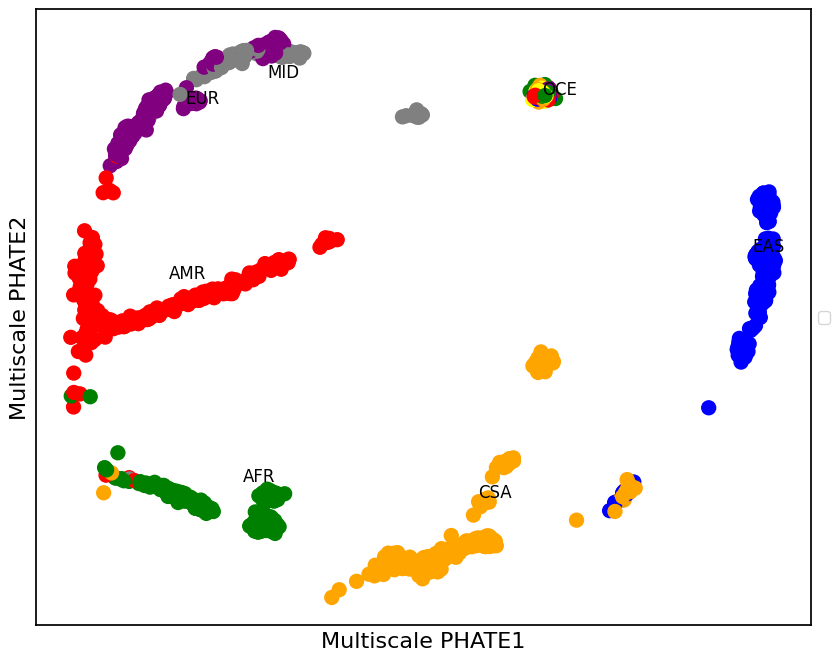

In [39]:
labs_to_plot = metadata_msphate[metadata_msphate['level'] == levels[0]]['Superpopulation']
graph_viz_utils.plot_msphate(msp_op, 
             levels, 
             level_ind=6, 
             palette=pop_palette_hgdp_coarse, 
             labels=labs_to_plot)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


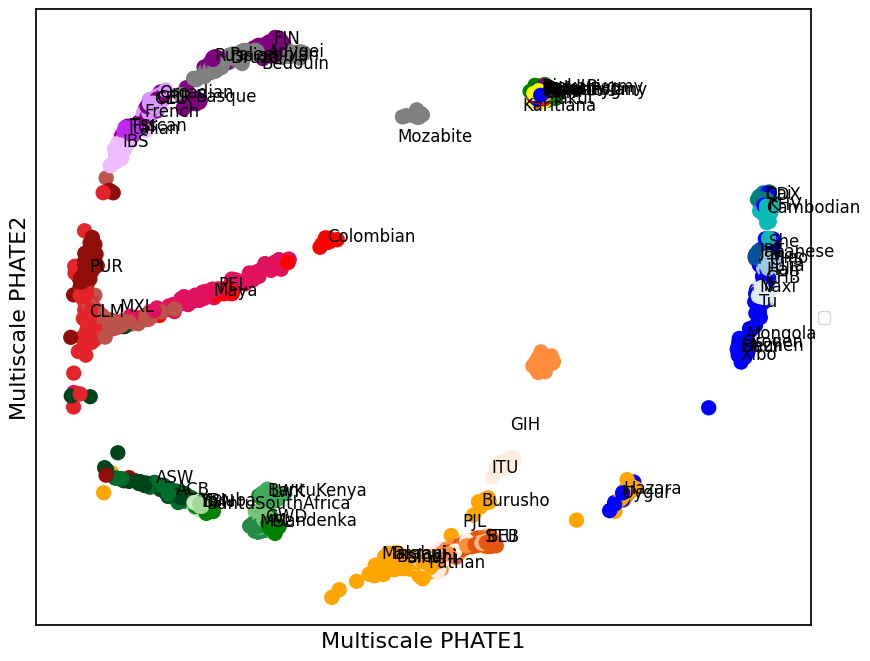

In [40]:
labs_to_plot = metadata_msphate[metadata_msphate['level'] == levels[0]]['Population']
graph_viz_utils.plot_msphate(msp_op, 
             levels, 
             level_ind=6, 
             palette=pop_palette_hgdp_fine, 
             labels=labs_to_plot)